**Conext**

**Cityscapes data** contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the [Pix2Pix](https://phillipi.github.io/pix2pix/) paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks.

**Content**

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

**Dataset:** 

https://www.kaggle.com/dansbecker/cityscapes-image-pairs

**References:** 

*   https://arxiv.org/pdf/1603.07285v1.pdf
*   https://towardsdatascience.com/u-net-b229b32b4a71



### 1. Setup Libraries & device

In [1]:
import os
import pickle
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


### 2. Configure data locations

In [3]:
# !kaggle datasets download -d dansbecker/cityscapes-image-pairs
# !unzip cityscapes-image-pairs.zip

In [4]:
data_dir = "./cityscapes_data"
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


### 3. Analyze data

./cityscapes_data/train/936.jpg


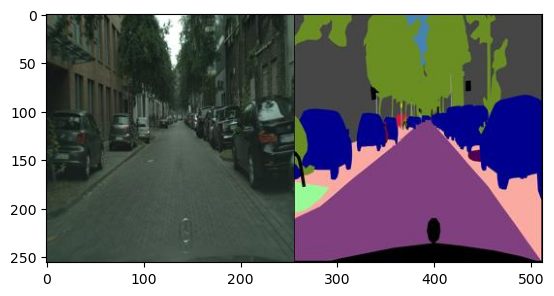

In [5]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

### 4. Extract Image and Labels

The input images contain both the road scene and the corresponding label in the same image. Thus, we are splitting it and presenting it as two separate entities.

In [6]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

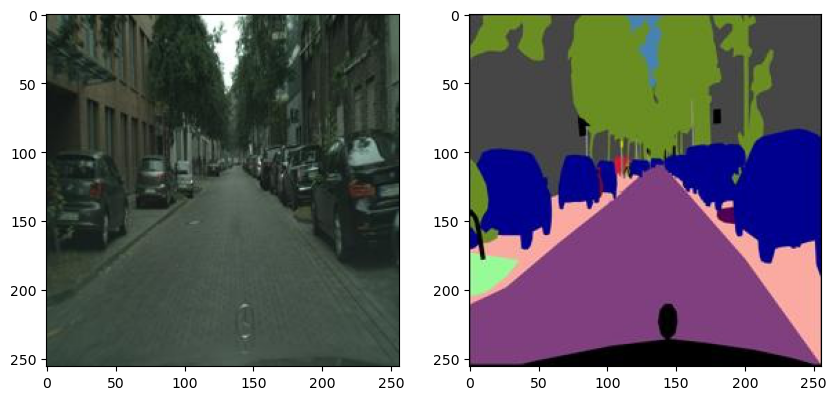

In [7]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

### 5. Define Labels

We use K-means clustering to segregate the objects of different colors and assign them class labels.   

In [8]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [9]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes,n_init=10)
label_model.fit(color_array)

KMeans(n_clusters=10, n_init=10)

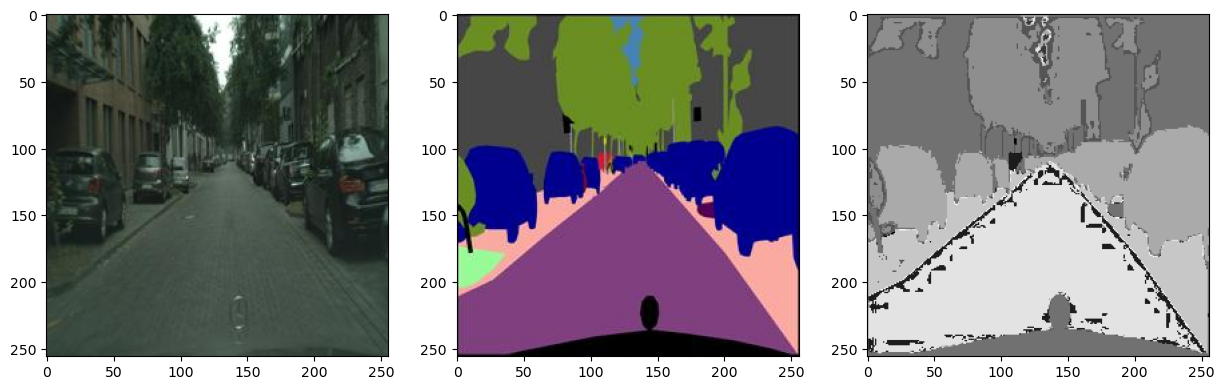

In [10]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class,cmap="gray")

In [11]:
label_class

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 3, 7, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]], dtype=int32)

### 6. Define Dataset

In [12]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label
  
  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [13]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [14]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


# Q1.1) UNet with Skip Connections

### 7. Define Model 


In [15]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [16]:
model = UNet(num_classes=num_classes)

In [17]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

# Iterate through the data loader and get the first batch of data
for X, Y in data_loader:
    # Print the shape of the input (X) and target (Y) tensors
    print("Shape of input tensor X:", X.shape)
    print("Shape of target tensor Y:", Y.shape)
    # Since we only want the first batch, break the loop
    break

2975 744
Shape of input tensor X: torch.Size([4, 3, 256, 256])
Shape of target tensor Y: torch.Size([4, 256, 256])


In [18]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


### 8. Train the model

In [19]:
batch_size = 16

epochs = 1
lr = 0.01

In [20]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [21]:
model = UNet(num_classes = num_classes).to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [23]:
model_name = "U-Net.pth"
step_loss_file = "step_loss_skip.pkl"
epoch_loss_file = "epoch_loss_skip.pkl"

if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))
    with open(step_loss_file, "rb") as f:
        step_losses = pickle.load(f)
    with open(epoch_loss_file, "rb") as f:
        epoch_losses = pickle.load(f)
else:
    step_losses = []
    epoch_losses = []
    
    for epoch in tqdm(range(epochs), desc="Epochs"):
        epoch_loss = 0
        model.train()  # Set the model to train mode
        for X, Y in tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            step_losses.append(loss.item())
        
        epoch_loss /= len(data_loader)
        epoch_losses.append(epoch_loss)
    
    # Save model state dict and losses
    torch.save(model.state_dict(), model_name)
    with open(step_loss_file, "wb") as f:
        pickle.dump(step_losses, f)
    with open(epoch_loss_file, "wb") as f:
        pickle.dump(epoch_losses, f)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/186 [00:00<?, ?it/s]

/home2/srihari.bandarupalli/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home2/srihari.bandarupalli/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


- trained in 2 minutes 16 seconds

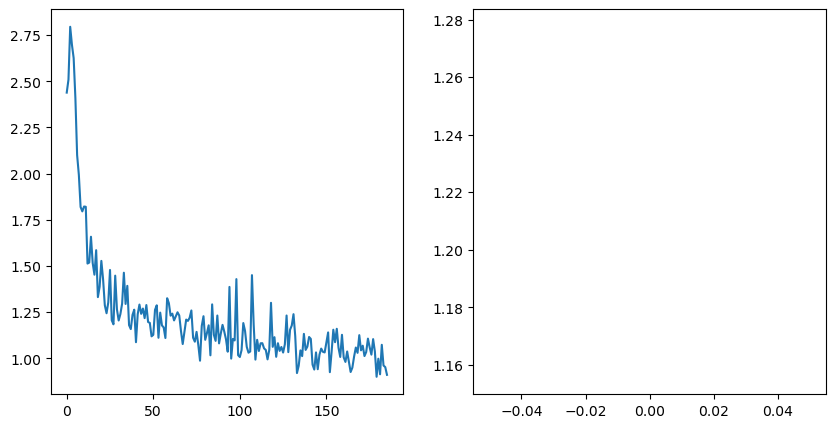

In [24]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

### 9. Check model predictions

In [25]:
def model_predict(model_path,model,num_classes,device,data_loader,test_batch_size):
    
    model_ = model(num_classes=num_classes).to(device)
    model_.load_state_dict(torch.load(model_path))
    X,Y = next(iter(data_loader))
    X,Y = X.to(device), Y.to(device)
    Y_pred = model_(X)
    print(Y_pred.shape)
    Y_pred = torch.argmax(Y_pred, dim=1)
    print(Y_pred.shape)
    inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))])
    fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

    iou_scores = []
    
    for i in range(test_batch_size):
        
        landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
        landscape = np.clip(landscape, 0, 1)
        label_class = Y[i].cpu().detach().numpy()
        label_class_predicted = Y_pred[i].cpu().detach().numpy()
        
        # IOU score
        intersection = np.logical_and(label_class, label_class_predicted)
        union = np.logical_or(label_class, label_class_predicted)
        iou_score = np.sum(intersection) / np.sum(union)
        iou_scores.append(iou_score)
    
        
        axes[i, 0].imshow(landscape)
        axes[i, 0].set_title("Landscape")
        axes[i, 1].imshow(label_class)
        axes[i, 1].set_title("Label Class")
        axes[i, 2].imshow(label_class_predicted)
        axes[i, 2].set_title("Label Class - Predicted")
    return iou_scores

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


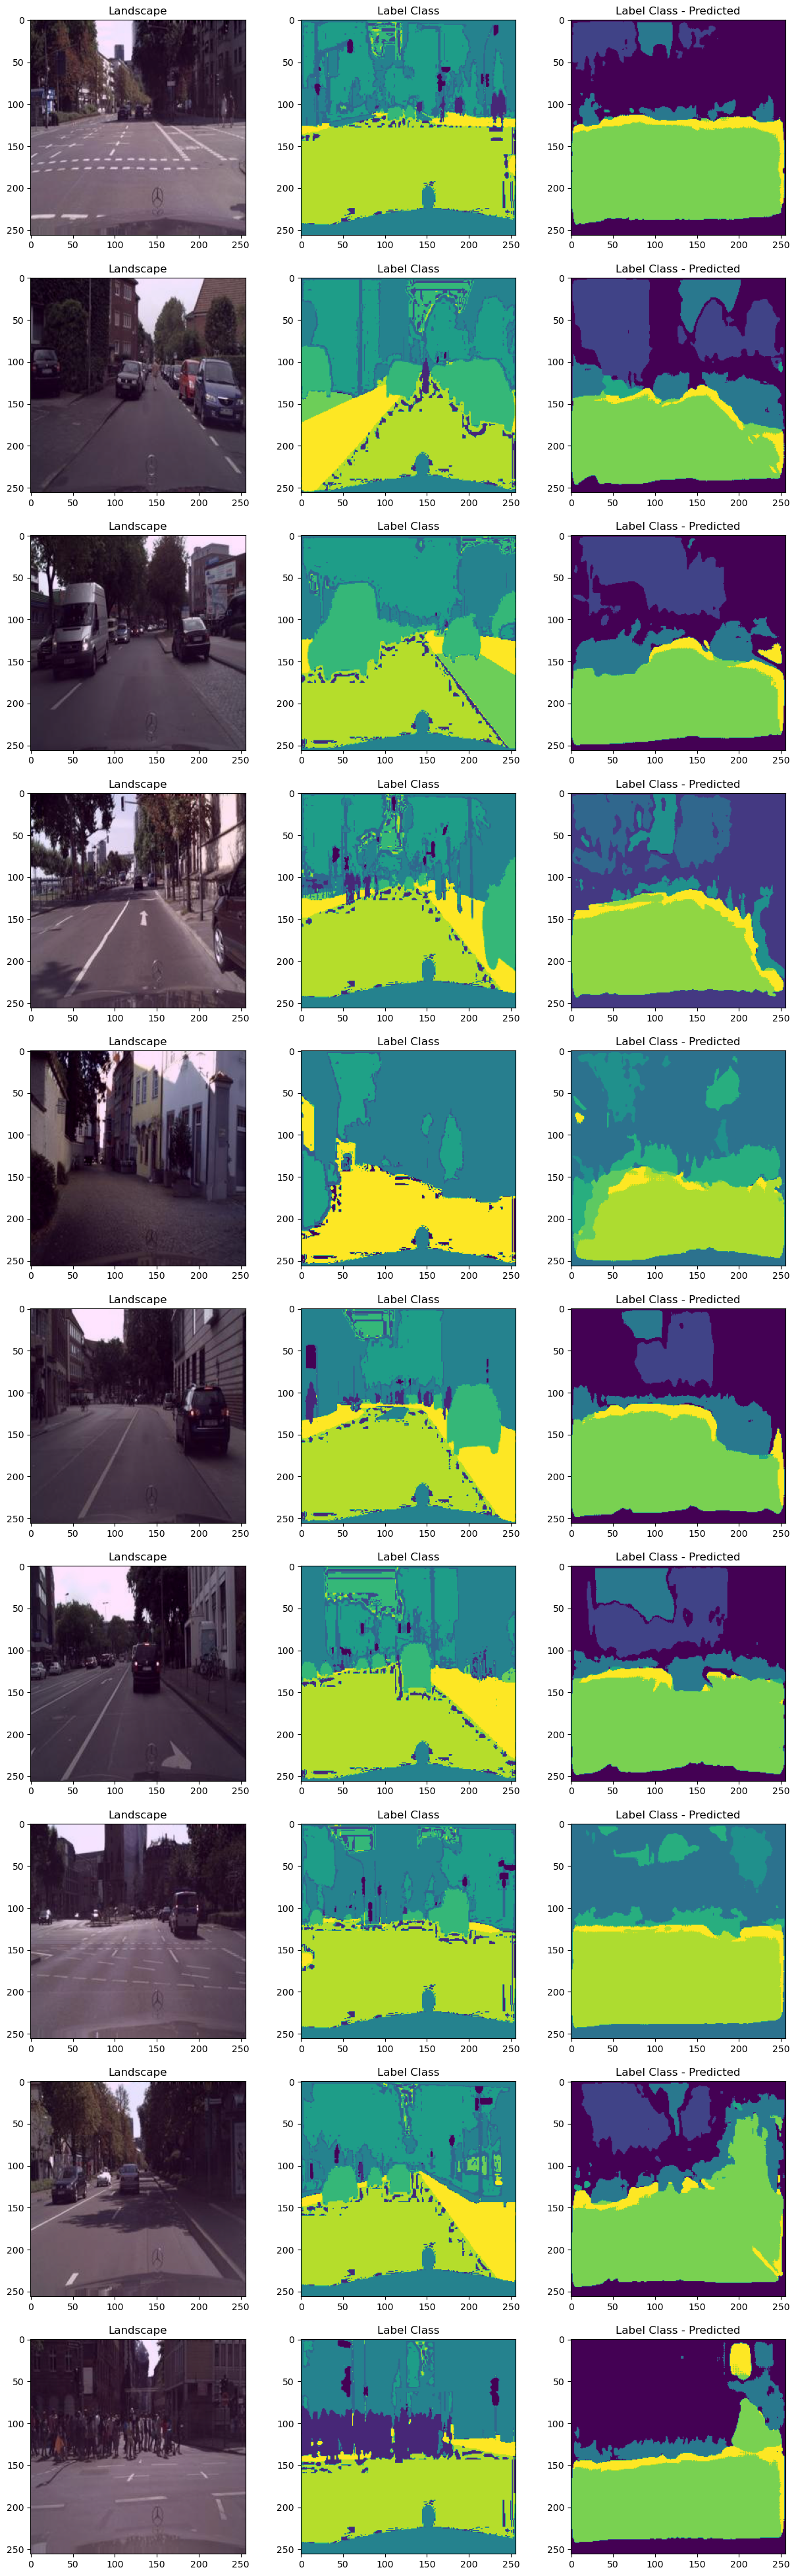

In [26]:
model_path = "U-Net.pth"
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)
iou_scores = model_predict(model_path,UNet,num_classes,device,data_loader,test_batch_size)

In [27]:
print(np.mean(iou_scores))

0.9944869995117187


In [28]:
print(sum(iou_scores) / len(iou_scores))

0.9944869995117187


# Q1.2) UNet without Skip Connections

### 7. Define Model 


In [29]:
class UNet_no_skip(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet_no_skip, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=512) # changed
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=256) # changed
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=128) # changed
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=64, out_channels=64) # changed
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(expansive_11_out) # [-1, 512, 32, 32] -> [-1, 512, 32, 32] # changed
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(expansive_21_out) # [-1, 256, 64, 64] -> [-1, 256, 64, 64] # changed
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(expansive_31_out) # [-1, 128, 128, 128] -> [-1, 128, 128, 128] # changed
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(expansive_41_out) # [-1, 64, 256, 256] -> [-1, 64, 256, 256] # changed
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [30]:
model = UNet_no_skip(num_classes=num_classes)

In [31]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

# Iterate through the data loader and get the first batch of data
for X, Y in data_loader:
    # Print the shape of the input (X) and target (Y) tensors
    print("Shape of input tensor X:", X.shape)
    print("Shape of target tensor Y:", Y.shape)
    # Since we only want the first batch, break the loop
    break

500 125
Shape of input tensor X: torch.Size([4, 3, 256, 256])
Shape of target tensor Y: torch.Size([4, 256, 256])


In [32]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


### 8. Train the model

In [33]:
batch_size = 16

epochs = 1
lr = 0.01

In [34]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [35]:
model = UNet_no_skip(num_classes = num_classes).to(device)

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [37]:
model_name = "U-Net_no_skip.pth"
step_loss_file = "step_loss_no_skip.pkl"
epoch_loss_file = "epoch_loss_no_skip.pkl"

if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))
    with open(step_loss_file, "rb") as f:
        step_losses = pickle.load(f)
    with open(epoch_loss_file, "rb") as f:
        epoch_losses = pickle.load(f)
else:
    step_losses = []
    epoch_losses = []
    
    for epoch in tqdm(range(epochs), desc="Epochs"):
        epoch_loss = 0
        model.train()  # Set the model to train mode
        for X, Y in tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            step_losses.append(loss.item())
        
        epoch_loss /= len(data_loader)
        epoch_losses.append(epoch_loss)
    
    # Save model state dict and losses
    torch.save(model.state_dict(), model_name)
    with open(step_loss_file, "wb") as f:
        pickle.dump(step_losses, f)
    with open(epoch_loss_file, "wb") as f:
        pickle.dump(epoch_losses, f)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/186 [00:00<?, ?it/s]

- trained in 1 minutes 32 seconds

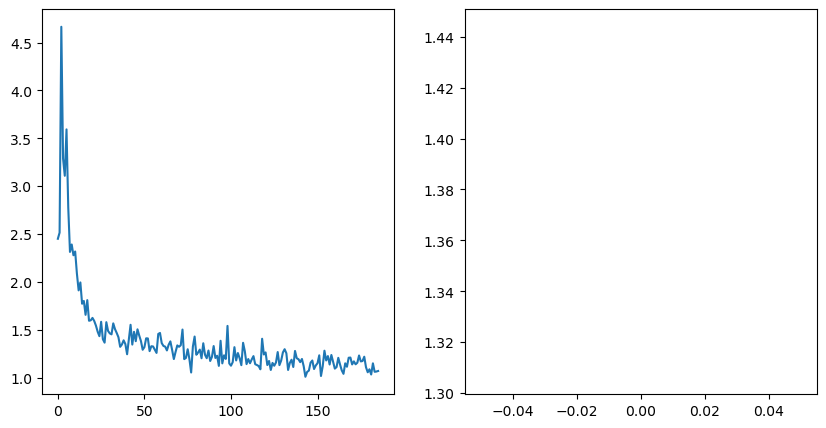

In [38]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

### 9. Check model predictions

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


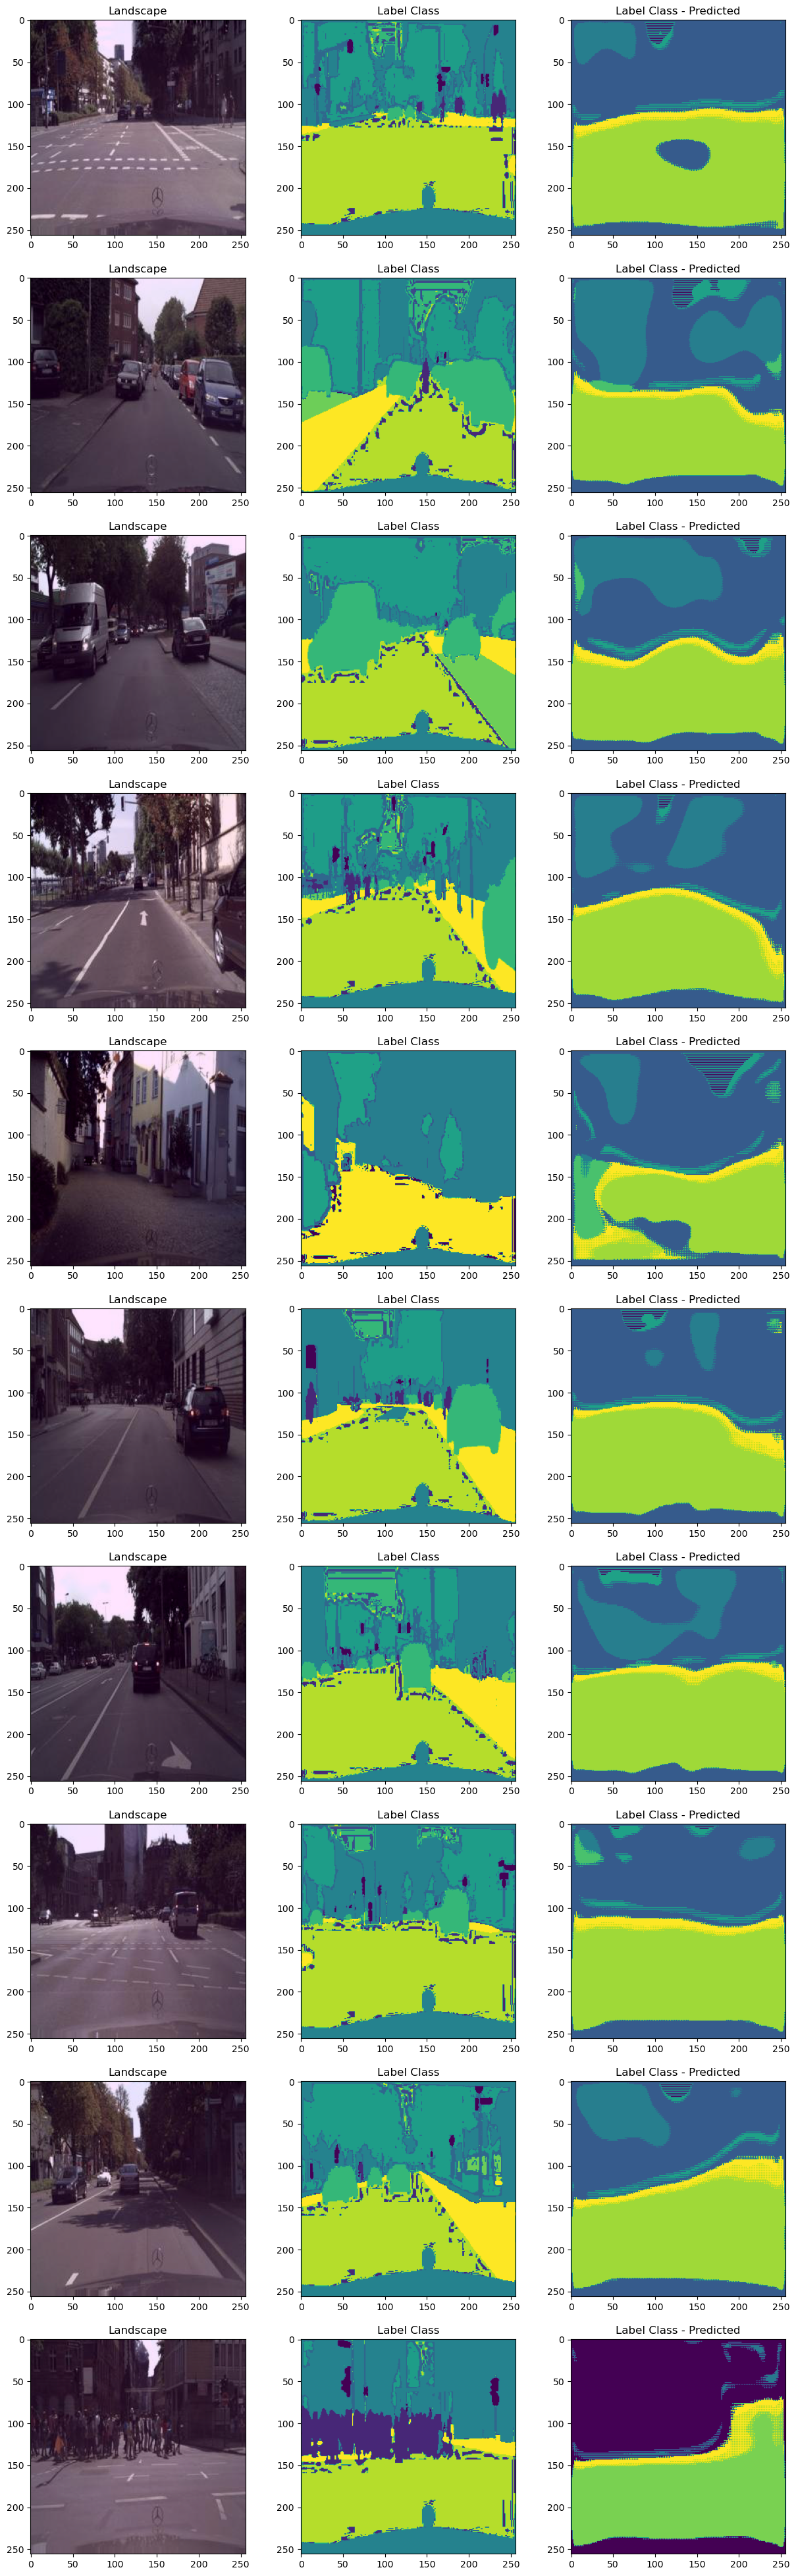

In [39]:
model_path = "U-Net_no_skip.pth"
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)
iou_scores = model_predict(model_path,UNet_no_skip,num_classes,device,data_loader,test_batch_size)

In [40]:
print(np.mean(iou_scores))

0.9944869995117187


# Q1.3)Metric

- The metric in the code uses `np.logical_and` and `np.logical_or` operations to compute IoU, which treat all non-zero values as `True`.
- This approach does not differentiate between different class labels in segmentation masks.
- Examples like `np.logical_and(1,0)` result in `False`, `np.logical_and(1,1)` result in `True`, and `np.logical_and(1,2)` also result in `True`, irrespective of specific class labels.

In [41]:
def compute_iou_per_class(label_class, label_class_predicted, num_classes):
    iou_scores = []
    
    for c in range(num_classes):
        intersection = np.logical_and(label_class == c, label_class_predicted == c)
        union = np.logical_or(label_class == c, label_class_predicted == c)
        
        # Avoid division by zero
        if np.sum(union) == 0:
            iou_scores.append(0.0)
        else:
            iou_scores.append(np.sum(intersection) / np.sum(union))
    
    return iou_scores

In [42]:
def model_predict_new(model_path,model,num_classes,device,data_loader,test_batch_size):
    
    model_ = model(num_classes=num_classes).to(device)
    model_.load_state_dict(torch.load(model_path))
    X,Y = next(iter(data_loader))
    X,Y = X.to(device), Y.to(device)
    Y_pred = model_(X)
    print(Y_pred.shape)
    Y_pred = torch.argmax(Y_pred, dim=1)
    print(Y_pred.shape)
    inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))])
    # fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

    iou_scores = []
    
    for i in range(test_batch_size):
        
        landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
        landscape = np.clip(landscape, 0, 1)
        label_class = Y[i].cpu().detach().numpy()
        label_class_predicted = Y_pred[i].cpu().detach().numpy()
        
        # IOU score
        iou_scores_per_class = compute_iou_per_class(label_class, label_class_predicted, num_classes)
        mean_iou_per_image = np.mean(iou_scores_per_class)
        iou_scores.append(mean_iou_per_image)
    return iou_scores

In [43]:
model_path = "U-Net.pth"
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)
iou_scores = model_predict_new(model_path,UNet,num_classes,device,data_loader,test_batch_size)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [44]:
print("iou for validataion set with skip_connections = ",np.mean(iou_scores))

iou for validataion set with skip_connections =  0.2195306391543494


In [45]:
model_path = "U-Net_no_skip.pth"
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)
iou_scores_no_skip = model_predict_new(model_path,UNet_no_skip,num_classes,device,data_loader,test_batch_size)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [46]:
print("iou for validataion set without skip connections = ",np.mean(iou_scores_no_skip))

iou for validataion set without skip connections =  0.1838122516776963


- **Role of Skip Connections**:
  - Skip connections in UNet preserve spatial information during upsampling.
  - They link encoder's feature maps to corresponding decoder's feature maps.
  - This integration helps retain fine details for accurate segmentation.

- **Effect on IoU**:
  - IoU measures overlap between predicted and ground truth masks.
  - Without skip connections, decoder lacks detailed contextual information.
  - Model struggles to delineate object boundaries accurately, leading to lower IoU.

- **Quantitative Comparison**:
  - Model with skip connections achieves higher IoU (0.2195) than without (0.1838).
  - Skip connections enable better capture of detailed features for accurate segmentation.